In [ ]:
# Graph Embedding

In [ ]:
## Football

In [7]:
### 使用DeepWalk

In [26]:
import os
path = os.path.expanduser('~/data/')

In [27]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [28]:
# 数据加载，构造图
G = nx.read_gml(path + 'BI/football.gml')
#球队总数
print(len(G)) 
#都有哪些球队
#print(G.nodes()) 
#都有哪些比赛
#print(G.edges()) 

""" 
随机游走
input: 将节点和被遍历的路径的长度作为输入
output: 返回遍历节点的顺序:
"""
def get_randomwalk(node, path_length):
    random_walk = [node]
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node        
    return random_walk

#print(get_randomwalk('EastCarolina', 10))
# 从图获取所有节点的列表
all_nodes = list(G.nodes())
# 捕获数据集中所有节点的随机游走序列
random_walks = []
for n in tqdm(all_nodes):
	# 每个节点游走5次，每次最长距离为10
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))
        

# 输出随机游走序列，及序列个数
#print(random_walks)
#print(len(random_walks))

# 使用skip-gram，提取模型学习到的权重
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

# 训练skip-gram (word2vec)模型
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # 负采样
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)


115


100%|██████████| 115/115 [00:00<00:00, 13298.00it/s]


In [33]:
# 从random_walks中创建词汇表
model.build_vocab(random_walks, progress_per=2)
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)
print(model)
# 输出和EastCarolina相似的球队
print(model.wv.most_similar('EastCarolina'))

Word2Vec(vocab=115, vector_size=100, alpha=0.03)
[('Louisville', 0.7614806890487671), ('WestVirginia', 0.7581599354743958), ('Cincinnati', 0.6976033449172974), ('Syracuse', 0.6683639883995056), ('Army', 0.6473052501678467), ('Memphis', 0.6404959559440613), ('FloridaState', 0.6280516386032104), ('AlabamaBirmingham', 0.6192911267280579), ('Temple', 0.6181203722953796), ('Tulane', 0.6173092722892761)]


In [45]:
# 在二维空间中绘制所选节点的向量
def plot_nodes(word_list):
	# 每个节点的embedding为100维
    X = model[word_list]
    #print(type(X))
    # 将100维向量减少到2维
    pca = PCA(n_components=2)
    result = pca.fit_transform(X) 
    #print(result)
    # 绘制节点向量
    plt.figure(figsize=(12,9))
    # 创建一个散点图的投影
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.show()
# 将所有的球队embedding进行绘制
# plot_nodes(model.wv.key_to_index)
plot_nodes(model.wv.vocab)

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [10]:
### 使用简单numpy实现GCN


In [46]:
import networkx as nx
from networkx import to_numpy_matrix
import matplotlib.pyplot as plt
import numpy as np

In [47]:
# 对网络G进行可视化
def plot_graph(G):
    plt.figure()
    pos = nx.spring_layout(G)
    edges = G.edges()
    nx.draw_networkx(G, pos, edges)
    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_size=300, node_color='r', alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=edges,alpha =0.4)
    plt.show()
    

In [48]:
# 数据加载，构造图
G = nx.read_gml(path + 'BI/football.gml')
#print(G)
#print(type(G))

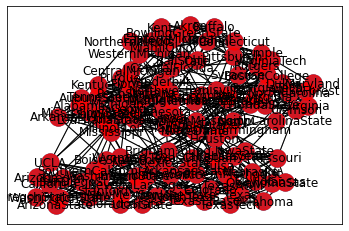

['BrighamYoung', 'FloridaState', 'Iowa', 'KansasState', 'NewMexico', 'TexasTech', 'PennState', 'SouthernCalifornia', 'ArizonaState', 'SanDiegoState', 'Baylor', 'NorthTexas', 'NorthernIllinois', 'Northwestern', 'WesternMichigan', 'Wisconsin', 'Wyoming', 'Auburn', 'Akron', 'VirginiaTech', 'Alabama', 'UCLA', 'Arizona', 'Utah', 'ArkansasState', 'NorthCarolinaState', 'BallState', 'Florida', 'BoiseState', 'BostonCollege', 'WestVirginia', 'BowlingGreenState', 'Michigan', 'Virginia', 'Buffalo', 'Syracuse', 'CentralFlorida', 'GeorgiaTech', 'CentralMichigan', 'Purdue', 'Colorado', 'ColoradoState', 'Connecticut', 'EasternMichigan', 'EastCarolina', 'Duke', 'FresnoState', 'OhioState', 'Houston', 'Rice', 'Idaho', 'Washington', 'Kansas', 'SouthernMethodist', 'Kent', 'Pittsburgh', 'Kentucky', 'Louisville', 'LouisianaTech', 'LouisianaMonroe', 'Minnesota', 'MiamiOhio', 'Vanderbilt', 'MiddleTennesseeState', 'Illinois', 'MississippiState', 'Memphis', 'Nevada', 'Oregon', 'NewMexicoState', 'SouthCarolina', 

In [49]:
# 可视化
plot_graph(G)
print(list(G.nodes()))
print(G.nodes['BrighamYoung']['value'])
#print(G.nodes)
#print(G.nodes[:,'value'])

In [50]:
# 构建GCN，计算A_hat和D_hat矩阵
order = sorted(list(G.nodes()))
#按照字母顺序排序
print(order)
A = to_numpy_matrix(G, nodelist=order)
#邻接矩阵
print('A=\n', A) 

['AirForce', 'Akron', 'Alabama', 'AlabamaBirmingham', 'Arizona', 'ArizonaState', 'Arkansas', 'ArkansasState', 'Army', 'Auburn', 'BallState', 'Baylor', 'BoiseState', 'BostonCollege', 'BowlingGreenState', 'BrighamYoung', 'Buffalo', 'California', 'CentralFlorida', 'CentralMichigan', 'Cincinnati', 'Clemson', 'Colorado', 'ColoradoState', 'Connecticut', 'Duke', 'EastCarolina', 'EasternMichigan', 'Florida', 'FloridaState', 'FresnoState', 'Georgia', 'GeorgiaTech', 'Hawaii', 'Houston', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'IowaState', 'Kansas', 'KansasState', 'Kent', 'Kentucky', 'LouisianaLafayette', 'LouisianaMonroe', 'LouisianaState', 'LouisianaTech', 'Louisville', 'Marshall', 'Maryland', 'Memphis', 'MiamiFlorida', 'MiamiOhio', 'Michigan', 'MichiganState', 'MiddleTennesseeState', 'Minnesota', 'Mississippi', 'MississippiState', 'Missouri', 'Navy', 'Nebraska', 'Nevada', 'NevadaLasVegas', 'NewMexico', 'NewMexicoState', 'NorthCarolina', 'NorthCarolinaState', 'NorthTexas', 'NorthernIllinois', '

In [51]:
# 生成对角矩阵
I = np.eye(G.number_of_nodes())
A_hat = A + I
print('A_hat=\n', A_hat)

# D_hat为A_hat的度矩阵
D_hat = np.array(np.sum(A_hat, axis=0))[0]
print('D_hat=\n', D_hat)
# 得到对角线上的元素
D_hat = np.matrix(np.diag(D_hat))
print('D_hat=\n', D_hat)

A_hat=
 [[1. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 0. 1.]]
D_hat=
 [11. 12. 12. 11. 12. 12. 11. 11. 12. 12. 11. 11. 10. 12. 12. 13. 12. 12.
  9. 12. 12. 11. 12. 11.  8. 12. 12. 12. 12. 13. 12. 11. 12. 12. 12. 10.
 12. 12. 13. 12. 11. 13. 11. 11.  9.  9. 11. 11. 11. 11. 12. 12. 11. 12.
 12. 12. 10. 12. 12. 12. 11. 12. 12. 13. 13. 12. 12. 12. 12. 11. 11. 12.
 12. 11. 12. 12. 11. 12. 11. 13. 12. 12. 12. 11. 12. 12. 12. 13. 13. 11.
 12. 12. 12. 12. 12. 12. 12. 12. 13. 10. 12. 13. 12. 12. 10. 12. 11. 12.
 11. 12. 12. 12. 11. 13. 12.]
D_hat=
 [[11.  0.  0. ...  0.  0.  0.]
 [ 0. 12.  0. ...  0.  0.  0.]
 [ 0.  0. 12. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 11.  0.  0.]
 [ 0.  0.  0. ...  0. 13.  0.]
 [ 0.  0.  0. ...  0.  0. 12.]]


In [52]:
# 初始化权重, normal 正态分布 loc均值 scale标准差
W_1 = np.random.normal(loc=0, scale=1, size=(G.number_of_nodes(), 4))
W_2 = np.random.normal(loc=0, size=(W_1.shape[1], 2))
print('W_1=\n', W_1)
print('W_2=\n', W_2)


# x<0时 结果=0; x>=0时，结果=x
def relu(x):
    return(abs(x)+x)/2

# 叠加GCN层，这里只使用单位矩阵作为特征表征，即每个节点被表示为一个 one-hot 编码的类别变量
def gcn_layer(A_hat, D_hat, X, W):
	return relu(D_hat**-1 * A_hat * X * W)
H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2
print('output=\n', output)
# 提取特征表征
feature_representations = {}
nodes = list(G.nodes())
for i in range(len(nodes)):
    feature_representations[nodes[i]] = np.array(output)[i]
print('feature_representations=\n', feature_representations)

W_1=
 [[ 1.26380926e+00  3.31652412e-01 -8.29733600e-01  4.99737340e-01]
 [-1.51195785e+00  4.27796298e-01 -5.51416067e-02  2.72689657e-01]
 [-1.39602274e-01  3.27275056e-01 -9.01386457e-01  1.65448958e-01]
 [-1.33222027e+00 -3.07536259e-02 -1.96904470e+00  4.13602479e-01]
 [-5.37200278e-01  7.11832514e-01 -1.35679719e+00  1.09527159e+00]
 [-1.70557487e-02  1.30698129e+00 -1.41035506e+00 -3.99658609e-01]
 [-3.27595520e-01 -3.36720241e-01 -3.95279221e-01 -8.02426585e-01]
 [-5.03770730e-01  1.67911517e+00  5.73387095e-01  1.58534001e-01]
 [-3.42736105e-01  5.65473291e-01 -1.01887301e-01  4.56074629e-01]
 [ 2.56139036e-01  5.08682734e-01  1.15586110e+00  8.13357240e-01]
 [-5.47666630e-01  7.15761606e-01  4.58897853e-01 -3.36616330e-01]
 [-1.99576471e+00  9.98953842e-01 -6.30195816e-01 -3.77223311e-01]
 [ 3.34319751e-01 -6.59194507e-01 -4.70114571e-01 -1.12124711e+00]
 [ 2.20626059e+00  2.12127017e-01 -8.30540506e-01 -3.62043632e-01]
 [ 5.72240436e-01  1.20295763e-01  2.63169342e-01  4.867

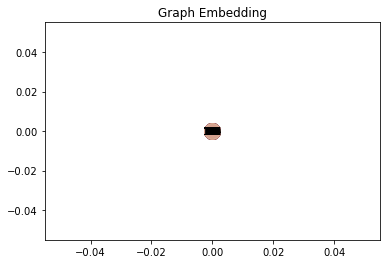

In [53]:
# 不同节点value，绘制不同的颜色
def getValue(value):
    colorList = ['blue','green','purple','yellow','red','pink','orange','black','white','gray','brown','wheat']
    return colorList[int(value)]
# 绘制output，节点GCN embedding可视化
def plot_node(output, title):
    for i in range(len(nodes)):
        node_name = nodes[i]
        value = G.nodes[node_name]['value']
        plt.scatter(np.array(output)[i,0],np.array(output)[i,1] ,label=str(i),color = getValue(value),alpha=0.5,s = 250)
        plt.text(np.array(output)[i,0],np.array(output)[i,1] ,i, horizontalalignment='center',verticalalignment='center', fontdict={'color':'black'})
    plt.title(title)
    plt.show()
plot_node(output, 'Graph Embedding')

output(去掉relu)=
: [[-0.1577094  -0.27955996]
 [-0.02666855  0.25371657]
 [ 0.08930927 -0.29198257]
 [ 0.25437141 -0.37209994]
 [-0.25007402 -0.85684007]
 [-0.22826    -0.76351887]
 [ 0.13167252  0.03514142]
 [-0.2483173  -0.28088499]
 [ 0.2086862  -0.35353981]
 [-0.1015767  -0.24429748]
 [ 0.11516204  0.61129093]
 [-0.98842994 -0.51393985]
 [ 0.03580789  0.3291867 ]
 [ 0.00986501 -0.57147905]
 [-0.1505931  -0.00957822]
 [-0.17164204 -0.43067913]
 [ 0.01391549  0.27704689]
 [-0.33098866 -0.92002621]
 [-0.13732145 -0.11330728]
 [-0.00319044  0.4825071 ]
 [ 0.25064702 -0.23266807]
 [ 0.0373837  -0.25787457]
 [-0.75940742 -0.55669141]
 [-0.49441744 -0.58822891]
 [ 0.07376942  0.11232242]
 [ 0.04734644 -0.27487697]
 [ 0.26026977 -0.47248211]
 [ 0.18816761  0.46571844]
 [ 0.18351385  0.12424091]
 [ 0.11597436 -0.30713312]
 [-0.99647695 -1.02259367]
 [ 0.09600923  0.21944061]
 [ 0.12029168 -0.25039475]
 [-1.09872384 -1.08341052]
 [-0.03929187 -0.67884427]
 [ 0.03717014 -0.15651158]
 [-0.38630

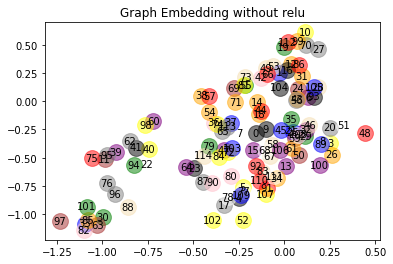

In [54]:
# 尝试去掉激活函数relu，重新运行一遍，发现效果反而更好
def gcn_layer(A_hat, D_hat, X, W):
    return D_hat**-1 * A_hat * X * W
H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2
print("output(去掉relu)=\n:",output)

plot_node(output, 'Graph Embedding without relu')

In [55]:
### 使用Graph Embedding中的DeepWalk对space_data进行压缩

In [59]:
from ge.classify import read_node_label, Classifier
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
from ge.model import DeepWork
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'ge.classify'

In [60]:
import os
path = os.path.expanduser('~/data/')

In [61]:
#tsv文件提取区别在 \t
df = pd.read_csv('~/data/BI/seealsology-data.tsv',sep = '\t')
# df.head()
G=nx.from_pandas_edgelist(df,'source','target',edge_attr=True)

In [62]:
# 数据加载，构造图
#G = nx.read_gml('football.gml')

# 初始化Node2Vec模型

In [63]:
model = DeepWalk(G, walk_length=10, num_walks=5, workers=1)
# 模型训练
model.train(window_size=4, iter=20)
# 得到节点的embedding
embeddings = model.get_embeddings()
#print(embeddings)
#print(embeddings.shape)
#print(type(embeddings))
#print(embeddings['lunar escape systems'])

NameError: name 'DeepWalk' is not defined

In [ ]:
# 在二维空间中绘制所选节点的向量
def plot_nodes(word_list):
    # 每个节点的embedding为100维
    X = []
    for item in word_list:
        X.append(embeddings[item])

    #print(X.shape)
    # 将100维向量减少到2维
    pca = PCA(n_components=2)
    result = pca.fit_transform(X) 
    #print(result)
    # 绘制节点向量
    plt.figure(figsize=(12,9))
    # 创建一个散点图的投影
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(list(word_list)):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))        
    plt.show()

plot_nodes(model.w2v_model.wv.vocab)
#s=model.similar_by_word('critical illness insurance')
#print(model.similar_by_word('critical illness insurance'))


""" 
随机游走
input: 将节点和被遍历的路径的长度作为输入
output: 返回遍历节点的顺序:
"""
def get_randomwalk(node, path_length):
    random_walk = [node]
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node        
    return random_walk

#print(get_randomwalk('EastCarolina', 10))
# 从图获取所有节点的列表
all_nodes = list(G.nodes())
# 捕获数据集中所有节点的随机游走序列
random_walks = []
for n in tqdm(all_nodes):
	# 每个节点游走5次，每次最长距离为10
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))
        

# 输出随机游走序列，及序列个数
#print(random_walks)
#print(len(random_walks))

# 使用skip-gram，提取模型学习到的权重
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

# 训练skip-gram (word2vec)模型
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # 负采样
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)
# 从random_walks中创建词汇表
model.build_vocab(random_walks, progress_per=2)
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)
print(model)
# 输出和critical illness insurance相似
print(model.similar_by_word('critical illness insurance'))


# # 在二维空间中绘制所选节点的向量
# def plot_nodes(word_list):
# 	# 每个节点的embedding为100维
#     X = model[word_list]
#     #print(type(X))
#     # 将100维向量减少到2维
#     pca = PCA(n_components=2)
#     result = pca.fit_transform(X) 
#     #print(result)
#     # 绘制节点向量
#     plt.figure(figsize=(12,9))
#     # 创建一个散点图的投影
#     plt.scatter(result[:, 0], result[:, 1])
#     for i, word in enumerate(word_list):
#         plt.annotate(word, xy=(result[i, 0], result[i, 1]))
#     plt.show()

# plot_nodes(model.wv.vocab)